##Importing files

These are all the libraries needed in this part of the project for generating explanations and detecting hourly anomalous behaviour

In [ ]:
import numpy as np # for data handling
import matplotlib.pyplot as plt # for visualisations
import email # for handling email data format
import os # for converting folders to dataframe
from tqdm import tqdm # for examining loops
import pandas as pd # for handling and generating dataframes

##Downloading and Processing the dataset

###Downloading data
Downloading dataset from a sub-url of the given URL

In [ ]:
!wget http://www.cs.cmu.edu/~enron/enron_mail_20150507.tar.gz

--2020-03-31 15:03:36--  http://www.cs.cmu.edu/~enron/enron_mail_20150507.tar.gz
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 443254787 (423M) [application/x-gzip]
Saving to: ‘enron_mail_20150507.tar.gz’

enron_mail_20150507 100%[===================>] 422.72M  1.43MB/s    in 4m 34s  

2020-03-31 15:08:12 (1.54 MB/s) - ‘enron_mail_20150507.tar.gz’ saved [443254787/443254787]



###Extracting all files

Extracting all files and folders from the given folder.

In [ ]:
!tar -xvzf enron_mail_20150507.tar.gz

Streaming output truncated to the last 5000 lines.
maildir/campbell-l/all_documents/1572.
maildir/campbell-l/all_documents/759.
maildir/campbell-l/all_documents/538.
maildir/campbell-l/all_documents/876.
maildir/campbell-l/all_documents/321.
maildir/campbell-l/all_documents/990.
maildir/campbell-l/all_documents/1842.
maildir/campbell-l/all_documents/1460.
maildir/campbell-l/all_documents/1840.
maildir/campbell-l/all_documents/274.
maildir/campbell-l/all_documents/448.
maildir/campbell-l/all_documents/1692.
maildir/campbell-l/all_documents/400.
maildir/campbell-l/all_documents/224.
maildir/campbell-l/all_documents/188.
maildir/campbell-l/all_documents/1670.
maildir/campbell-l/all_documents/1678.
maildir/campbell-l/all_documents/706.
maildir/campbell-l/all_documents/254.
maildir/campbell-l/all_documents/1429.
maildir/campbell-l/all_documents/1704.
maildir/campbell-l/all_documents/529.
maildir/campbell-l/all_documents/1039.
maildir/campbell-l/all_documents/1694.
maildir/campbell-l/all_doc

##Preprocessing the dataset

Involves all needed transforms to interpret the data and then using for future tasks

###Creating dataframe

Converting data to table format for running various queries and processes.

In [ ]:
data = pd.DataFrame(columns = ['Message-ID','Date','From','To','Subject','Path','Origin','FileName','Content']) 
# All columns that will be extracted from the data

In [ ]:
mids = set() # for extracting only unique mails from the data as it very large
n = 0 # for limitting the process if it is too slow
row = 0 # selecting row of the table
lists = [[0 for _ in range(int(2e6))],[0 for _ in range(int(2e6))],[0 for _ in range(int(2e6))],
         [0 for _ in range(int(2e6))],[0 for _ in range(int(2e6))],[0 for _ in range(int(2e6))],
         [0 for _ in range(int(2e6))],[0 for _ in range(int(2e6))],[0 for _ in range(int(2e6))]]
         # data is initially stored as a list of lists. This is done because lists are comparatively faster for in allocation

# accessing all files in the root directory of the downloaded folders
for path, mid, files in tqdm(os.walk('maildir/')):
  n+=1
  if n>=400000: # limitting the process if too slow
    break
  for f in files:
    try: # rejecting the file in case of any error
      with open(path+'/'+f) as doc: # adding all email fields to the table
          e = email.message_from_string(doc.read())
          if e.get('Date') not in mids:
            mids.add(e.get('Message_ID'))
            lists[0][row] = e.get('Message-ID')
            lists[1][row] = e.get('Date')
            lists[2][row] = e.get('From')
            lists[3][row] = e.get('To')
            lists[4][row] = e.get('Subject')
            lists[5][row] = e.get('X-Folder')
            lists[6][row] = e.get('X-Origin')
            lists[7][row] = e.get('X-FileName')
            lists[8][row] = e.get_payload()
            row += 1
            mids.add(e.get('Date'))
    except:
      pass

3500it [01:46, 32.83it/s]


In [ ]:
i = 0 # Creating a pandas dataframe
for col in data.columns:
  data[col] = lists[i]
  i += 1

In [ ]:
data # checking the dataframe

,Message-ID,Date,From,To,Subject,Path,Origin,FileName,Content
0,<31779136.1075855170685.JavaMail.evans@thyme>,"Wed, 14 Nov 2001 12:17:27 -0800 (PST)",chris.hyde@enron.com,jay.reitmeyer@enron.com,db editor link,"\James_Reitmeyer_Jan2002_1\Reitmeyer, Jay\Jay'...",Reitmeyer-J,jreitme (Non-Privileged).pst,DB Editor:\nhttp://fundamentals.dev.corp.enron...
1,<14252528.1075852358710.JavaMail.evans@thyme>,"Thu, 25 Oct 2001 21:13:24 -0700 (PDT)",no.address@enron.com,None,Upcoming Wellness Activities,\JREITME (Non-Privileged)\Deleted Items,REITMEYER-J,JREITME (Non-Privileged).pst,\nCPR and First Aid Certification\nCPR and Fir...
2,<17588263.1075861427205.JavaMail.evans@thyme>,"Mon, 26 Nov 2001 16:04:00 -0800 (PST)",newhorizons@lists.em5000.com,jreitme@enron.com,FREE Shipping and handling at FINGERHUT.com,"\JREITME (Non-Privileged)\Reitmeyer, Jay\Delet...",Reitmeyer-J,JREITME (Non-Privileged).pst,FINGERHUT.com specail email offer\n\nShop now ...
3,<1063899.1075855171168.JavaMail.evans@thyme>,"Wed, 26 Dec 2001 16:11:22 -0800 (PST)",newexpectations@lists.em5000.com,jreitme@enron.com,"Post Holiday Special, Dish Network Satellite S...","\James_Reitmeyer_Jan2002_1\Reitmeyer, Jay\Dele...",Reitmeyer-J,jreitme (Non-Privileged).pst,CONGRATULATIONS!! \n\n* No Equipment To Buy!...
4,<4139706.1075855170941.JavaMail.evans@thyme>,"Fri, 21 Dec 2001 09:32:05 -0800 (PST)",annualgiving@aggienetwork.com,jreitme@enron.com,We need your help!,"\James_Reitmeyer_Jan2002_1\Reitmeyer, Jay\Dele...",Reitmeyer-J,jreitme (Non-Privileged).pst,Howdy!\n\nWe need your help! Earlier this wee...
...,...,...,...,...,...,...,...,...,...
1999995,0,0,0,0,0,0,0,0,0
1999996,0,0,0,0,0,0,0,0,0
1999997,0,0,0,0,0,0,0,0,0
1999998,0,0,0,0,0,0,0,0,0


In [ ]:
data = data[data['Date']!=0] # discarding all unneeded rows

In [ ]:
data.shape # verifying the shape of the data

(224071, 9)

In [ ]:
pd.to_datetime(data.Date[60678]) # converting the date field to date time type

Timestamp('2001-06-05 07:41:00-0700', tz='pytz.FixedOffset(-420)')

In [ ]:
data.Date[60679] # viewing and checking possible erroneous rows

'Tue, 29 May 2001 06:01:00 -0700 (PDT)'

#Anomaly Detection

##Processing for anomaly detection

###Adding content length as a column
This is also an important column for analysis as it indicates the length of the content of the emial and will be very helpful for flagging deviations from the general trends in the data. Mails which are not replies generally have much larger size than those which have which will be shown later.

In [ ]:
cl = [0 for i in range(len(data['Content']))] # generating and adding new column for content length
for i in range(len(data['Content'])):
  cl[i] = len(data['Content'][i])

In [ ]:
data['Content Length'] = cl # adding the content length column/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


###Adding a column for whether a mail is a  reply or not
This column will be used later as a field for anomaly detection. This column also indicates how many small conversations are going on as a feature in the dataset and will be visualised later. The column also shows that mails in it are generally shorter than normal which will also be demonstrated later.

In [ ]:
rees = [0 for i in range(len(data['Subject']))]
for i in range(len(data['Subject'])):
  if 'Re:' in data['Subject'][i]:
    rees[i] = 1

In [ ]:
data['Reply'] = rees

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


###Generating time series data
This involves grouping the data according to the hour and day. This data can then be used to perform time series analysis and anomaly detection. An aggregate like mean and count is generally taken for various fields which will be shown as and when being performed over all mails in that particular hour.

In [ ]:
data.Date = pd.to_datetime(data.Date, utc = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
times = pd.DatetimeIndex(data.Date) # generating time groups of the data

In [ ]:
data.Date

0        2002-02-14 19:34:47+00:00
1        2001-12-10 12:39:59+00:00
2        2002-02-11 13:15:26+00:00
3        2001-09-27 18:21:56+00:00
4        2001-09-27 18:42:13+00:00
                    ...           
224066   2001-11-05 18:09:16+00:00
224067   2001-11-05 18:10:17+00:00
224068   2001-11-03 00:51:20+00:00
224069   2001-11-05 18:05:10+00:00
224070   2001-08-01 02:17:00+00:00
Name: Date, Length: 224071, dtype: datetime64[ns, UTC]

In [ ]:
times.hour, times.date

(Int64Index([19, 12, 13, 18, 18, 12, 13, 12, 21, 12,
             ...
              0, 17, 20, 18, 18, 18, 18,  0, 18,  2],
            dtype='int64', name='Date', length=224071),
 array([datetime.date(2002, 2, 14), datetime.date(2001, 12, 10),
        datetime.date(2002, 2, 11), ..., datetime.date(2001, 11, 3),
        datetime.date(2001, 11, 5), datetime.date(2001, 8, 1)],
       dtype=object))

In [ ]:
grouped = data.groupby(by = (times.date, times.hour)) # grouping the data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


In [ ]:
x = np.array(grouped.count()['Message-ID']) # finding the count of mails in every hour and using it as a feature and for normalising other features

In [ ]:
x = np.column_stack([x,np.array(grouped.mean()[['Content Length','Reply']])]) # adding replies and count as columns to the data

In [ ]:
x.T[1] = x.T[1]/x.T[0] # normalising the data according to the count as the points will not be scaled otherwise
x.T[2] = x.T[2]/x.T[0]

In [ ]:
x

array([[  1.,  25.,   0.],
       [  1., 942.,   0.],
       [  1., 194.,   0.],
       ...,
       [  1., 215.,   0.],
       [  1., 152.,   0.],
       [  1., 225.,   0.]])

In [ ]:
x_m = x.mean(axis=0)

In [ ]:
x_m

array([1.23611739e+01, 7.40836737e+02, 6.59526977e-02])

In [ ]:
x_m = x.mean(axis=0) # normalising the data
x_s = x.std(axis=0)
x = (x-x_m)/x_s

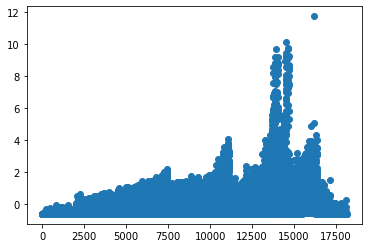

In [ ]:
plt.scatter([i for i in range(len(x))],x.T[0])

In the above graph which indicate the normalised count, the number of mails shoot up very fast in a very specific time frame which indicates anomalous behaviour in that period of 2 to 3 days. Similar anomolous hours are also seen about a week after that. This can also be a strong indicator of fraudulent activities like deletion of large amounts of records and other instructions being passed and expecting immediate reporting on the same.

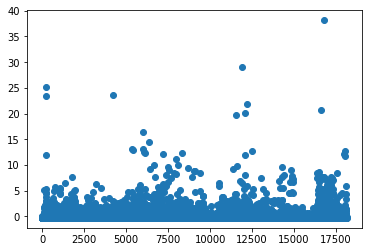

In [ ]:
plt.scatter([i for i in range(len(x))],x.T[1])

The sharp anomalous surges in the number of mails were seen to be preceeded by surges in the length of mails thus it is also a very important indicator of fraudulent activity.

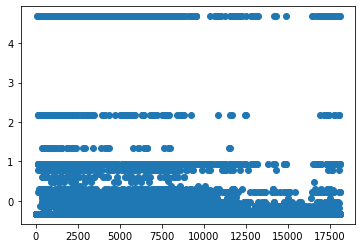

In [ ]:
plt.scatter([i for i in range(len(x))],x.T[2])

Number of replies in most conditions is very low or extremely high depending on the hour being considered. These points of multiple replies on the same topic can be of key interest in some cases.

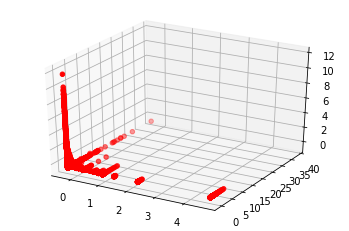

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x.T[2], x.T[1], x.T[0], c='r', marker='o')
plt.show()

In most cases anomalies are in one of the 3 dimensions and rarely in all them together. Some points are slightly anomalous in terms of length and replies but do not deviate significantly.

##Performing Anomaly detaction

###Isolation forests
This is an anomaly detection method which can be used in this case. It builds trees by performing random splits and on the data. Anomalies will be away from the data and thus will be differentiated the most from these random separation.

More details: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
if_model = IsolationForest(max_features=3, n_estimators=1000, verbose=2, contamination=0.01)
# verbose is to show the random separators
# n-estimators is the number of random differentiators
# contamination decides how much data should be separated as anomaly
# max_fearures decides how many features should be considered during a split

In [ ]:
if_model.fit(x) # finding the anomalies

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 1000 for this parallel run (total 1000)...
Building estimator 2 of 1000 for this parallel run (total 1000)...
Building estimator 3 of 1000 for this parallel run (total 1000)...
Building estimator 4 of 1000 for this parallel run (total 1000)...
Building estimator 5 of 1000 for this parallel run (total 1000)...
Building estimator 6 of 1000 for this parallel run (total 1000)...
Building estimator 7 of 1000 for this parallel run (total 1000)...
Building estimator 8 of 1000 for this parallel run (total 1000)...
Building estimator 9 of 1000 for this parallel run (total 1000)...
Building estimator 10 of 1000 for this parallel run (total 1000)...
Building estimator 11 of 1000 for this parallel run (total 1000)...
Building estimator 12 of 1000 for this parallel run (total 1000)...
Building estimator 13 of 1000 for this parallel run (total 1000)...
Building estimator 14 of 1000 for this parallel run (total 1000)...
Building estimator 15 of 1000 for this parallel run (tota

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s finished


IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.01,
                max_features=3, max_samples='auto', n_estimators=1000,
                n_jobs=None, random_state=None, verbose=2, warm_start=False)

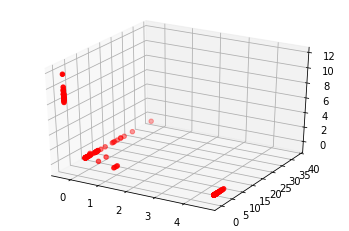

182


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[if_model.predict(x)<0.1].T[2], x[if_model.predict(x)<0.1].T[1], x[if_model.predict(x)<0.1].T[0], c='r', marker='o')
plt.show()
print(sum(if_model.predict(x)<0.1))
# using 0.1 as a threshold and printing the anomalies

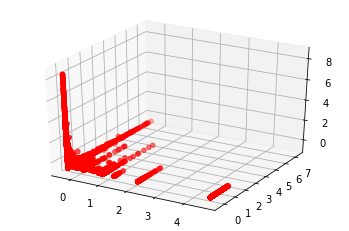

17945


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[if_model.predict(x)>0.1].T[2], x[if_model.predict(x)>0.1].T[1], x[if_model.predict(x)>0.1].T[0], c='r', marker='o')
plt.show()
print(sum(if_model.predict(x)>0.1))
# printing the considered data points

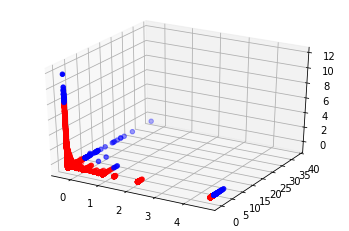

17945
182


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[if_model.predict(x)>0.1].T[2], x[if_model.predict(x)>0.1].T[1], x[if_model.predict(x)>0.1].T[0], c='r', marker='o')
ax.scatter(x[if_model.predict(x)<0.1].T[2], x[if_model.predict(x)<0.1].T[1], x[if_model.predict(x)<0.1].T[0], c='b', marker='o')
plt.show()
print(sum(if_model.predict(x)>0.1))
print(sum(if_model.predict(x)<0.1))

###Local Outlier Factor
This is another method for finding outliers which uses distances from nearest neighbours and thus does separation based on density. More can be learnt at: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
lof_model = LocalOutlierFactor(novelty=True,n_neighbors=500)
# novelty helps in detecting new features using k nearest neighbours
# n-neighbours helps in deciding the density for outlier

In [ ]:
lof_model.fit(x)

LocalOutlierFactor(algorithm='auto', contamination='auto', leaf_size=30,
                   metric='minkowski', metric_params=None, n_jobs=None,
                   n_neighbors=500, novelty=True, p=2)

In [ ]:
sum(lof_model.predict(x)==1)

16940

In [ ]:
sum(lof_model.predict(x)==-1)

1187

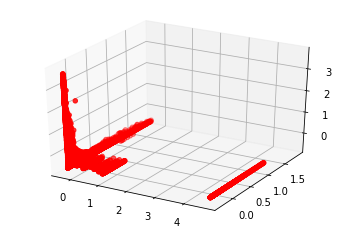

16940


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[lof_model.predict(x)==1].T[2], x[lof_model.predict(x)==1].T[1], x[lof_model.predict(x)==1].T[0], c='r', marker='o')
plt.show()
print(sum(lof_model.predict(x)==1))
# data seems to have very high density in 2 major regions. Both need to analysed. Most anomalies are way further.

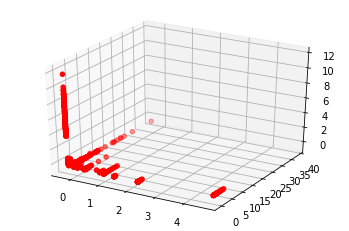

1187


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[lof_model.predict(x)==-1].T[2], x[lof_model.predict(x)==-1].T[1], x[lof_model.predict(x)==-1].T[0], c='r', marker='o')
plt.show()
print(sum(lof_model.predict(x)==-1))
# printing outliers which seem to be distributed all around the data which is not expected

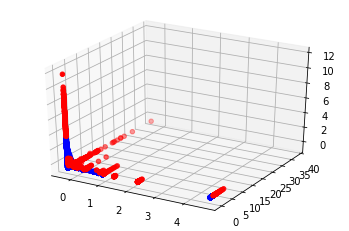

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[lof_model.predict(x)==-1].T[2], x[lof_model.predict(x)==-1].T[1], x[lof_model.predict(x)==-1].T[0], c='r', marker='o')
ax.scatter(x[lof_model.predict(x)==1].T[2], x[lof_model.predict(x)==1].T[1], x[lof_model.predict(x)==1].T[0], c='b', marker='o')
plt.show()

Local Outlier Factor doesn't seem to work very well in this dataset as shown and thus Isolation forests will be used.

##Generated more graph based features
These features are being generated after referring various research papers which have indicated that most anomalies involving fraud had communications which between entities which were not communicating earlier. It also involved high fraction of communications with external entities which again will be considered for feature engineering.

Research papers:
<ul>
<li>https://www.cs.cmu.edu/~deswaran/papers/kdd18-spotlight.pdf
<li>https://www.cs.cmu.edu/~deswaran/papers/icdm18-sedanspot.pdf
<li>https://www.andrew.cmu.edu/user/lakoglu/pubs/oddball_TR.pdf
</ul>

###Creating count of mail sent by every source and receivers

In [ ]:
from_count = {} 
for i in data.From:
  if i not in from_count.keys():
    from_count[i] = 1
  else:
    from_count[i] +=1

In [ ]:
to_count = {} 
for i in data.To:
  if i not in to_count.keys():
    to_count[i] = 1
  else:
    to_count[i] +=1

In [ ]:
from_count

{'lkunkel@trigon-sheehan.com': 6,
 'darrell.schoolcraft@enron.com': 504,
 'tk.lohman@enron.com': 133,
 'ron.matthews@enron.com': 59,
 'jeanne.licciardo@enron.com': 4,
 'michelle.lokay@enron.com': 426,
 'david.roensch@enron.com': 50,
 'elizabeth.brown@enron.com': 79,
 'mansoor.abdmoulaie@enron.com': 37,
 'richard.hanagriff@enron.com': 59,
 'melinda.gallishaw@enron.com': 15,
 'max.brown@enron.com': 6,
 'maria.salazar@enron.com': 1,
 'enron.payroll@enron.com': 29,
 'michael.bodnar@enron.com': 71,
 'john.sturn@enron.com': 17,
 'ramona.betancourt@enron.com': 39,
 'rc@mail.greeting-cards.com': 3,
 'team.cunningham@enron.com': 4,
 'newsletter@rigzone.com': 69,
 'charlie.yuan@enron.com': 1,
 'bart.monden@enron.com': 8,
 'mschneider@duke-energy.com': 32,
 'jerry.graves@enron.com': 154,
 'toby.kuehl@enron.com': 48,
 'stoverron1@aol.com': 1,
 'lynn.blair@enron.com': 987,
 'steve.january@enron.com': 53,
 'nancy.callans@enron.com': 21,
 'thill@cfbc.org': 1,
 'randy.janzen@enron.com': 63,
 'sharon.b

Count of emails sent by every source

(array([1.8707e+04, 4.8000e+01, 1.5000e+01, 5.0000e+00, 2.0000e+00,
        1.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00, 3.0000e+00]),
 array([1.0000e+00, 4.2080e+02, 8.4060e+02, 1.2604e+03, 1.6802e+03,
        2.1000e+03, 2.5198e+03, 2.9396e+03, 3.3594e+03, 3.7792e+03,
        4.1990e+03]),
 <a list of 10 Patch objects>)

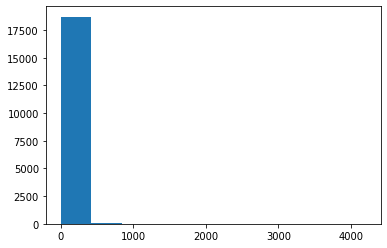

In [ ]:
plt.hist([from_count[i] for i in from_count.keys()]) # a few mails seem outliers and have sent more than 500 mails

In [ ]:
senders = list(from_count.keys())
senders.sort(key = lambda x: from_count[x], reverse=True)

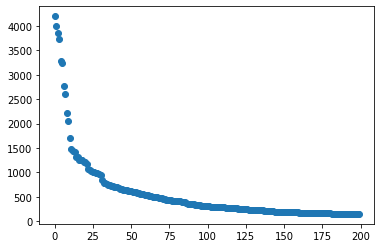

In [ ]:
plt.scatter([i for i in range(len(senders))][:200], [from_count[k] for k in senders][:200])

Most of the mails have been sent by the top 200 employees and thus it would be more relevent to consider only their data for general so that external factors don't influence significantly.

In [ ]:
unique_from_count = from_count

In [ ]:
# cleaning all recipients and separating them
unique_to_count = dict()
for i in to_count.keys():
  s = i
  try:
    s = s.replace('\n','').replace('\t','').replace('e-mail','').replace('<','').replace('>','').replace('.','').replace(' ','').replace("''",'').replace("'",'')
    if ',' in s:
      for mail in s.split(','):
        if mail in unique_to_count.keys():
          unique_to_count[mail] += to_count[i]
        else:
          unique_to_count[mail] = to_count[i]
    else:
      if i.To in unique_to_count.keys():
        unique_to_count[mail] += to_count[i]
      else:
        unique_to_count[mail] = to_count[i]
  except:
    pass

In [ ]:
unique_to_count

{'stevejanuary@enroncom': 427,
 'stevenharris@enroncom': 1291,
 'kimberlywatson@enroncom': 1210,
 'tklohman@enroncom': 1197,
 'michellelokay@enroncom': 1183,
 'debbiemoseley@enroncom': 112,
 'janmoore@enroncom': 488,
 'darrellschoolcraft@enroncom': 836,
 'berthernandez@enroncom': 298,
 'davidroensch@enroncom': 217,
 'johnbuchanan@enroncom': 647,
 'jerrygraves@enroncom': 263,
 'perryfrazier@enroncom': 191,
 'tobykuehl@enroncom': 163,
 'pattyhermanek@enroncom': 16,
 'ramonabetancourt@enroncom': 209,
 'shelleycorman@enroncom': 1115,
 'paulybarbo@enroncom': 679,
 'markmcconnell@enroncom': 524,
 'danpribble@enroncom': 244,
 'lynnblair@enroncom': 1044,
 'rickdietz@enroncom': 590,
 'terrykowalke@enroncom': 705,
 'lindydonoho@enroncom': 1047,
 'bradleyholmes@enroncom': 322,
 'ritabianchi@enroncom': 116,
 'arniebailey@enroncom': 85,
 'ricksmith@enroncom': 107,
 'bobbandel@enroncom': 54,
 'johnford@enroncom': 24,
 'randyhoward@enroncom': 84,
 'fredjordan@enroncom': 99,
 'rlawrence@enroncom': 18,

In [ ]:
receivers = list(unique_to_count.keys())
receivers.sort(key = lambda x: unique_to_count[x], reverse=True)

In [ ]:
receivers

['richardshapiro@enroncom',
 'jeffdasovich@enroncom',
 'susanmara@enroncom',
 'louisekitchen@enroncom',
 'timbelden@enroncom',
 'paulkaufman@enroncom',
 'jamessteffes@enroncom',
 'tanajones@enroncom',
 'sarashackleton@enroncom',
 'stevenkean@enroncom',
 'marktaylor@enroncom',
 'johnlavorato@enroncom',
 'harrykingerski@enroncom',
 'sallybeck@enroncom',
 'gregwhalley@enroncom',
 'alancomnes@enroncom',
 'sarahnovosel@enroncom',
 'karendenne@enroncom',
 'elizabethsager@enroncom',
 'susanbailey@enroncom',
 'lindarobertson@enroncom',
 'geraldnemec@enroncom',
 'dsteffes@enroncom',
 'stevenharris@enroncom',
 'joehartsoe@enroncom',
 'lorrainelindberg@enroncom',
 'kimberlywatson@enroncom',
 'sandramccubbin@enroncom',
 'tklohman@enroncom',
 'michellelokay@enroncom',
 'marycook@enroncom',
 'jeffrichter@enroncom',
 'shelleycorman@enroncom',
 'richardsanders@enroncom',
 'stephaniepanus@enroncom',
 'rickbuy@enroncom',
 'lindydonoho@enroncom',
 'lynnblair@enroncom',
 'brenthendry@enroncom',
 'robertba

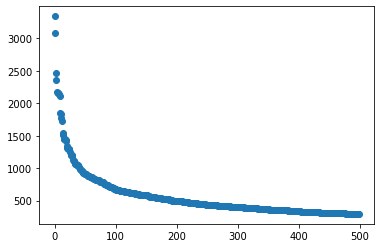

In [ ]:
plt.scatter([i for i in range(len(receivers))][:500], [unique_to_count[k] for k in receivers][:500])

Top 500 recipients have actually received most of the emails in the organisation.

In [ ]:
unique_to_count[receivers[1000]]

177

###Creating count of every pair of source and destination
Creating a new feature for every pair involved in a mail. This will help in identifying new novel communication patterns.

In [ ]:
unique_pair_count = dict()
for i in data.index:
  s = data.To[i]
  source = data.From[i]
  try:
    s = s.replace('\n','').replace('\t','').replace('e-mail','').replace('<','').replace('>','').replace('.','').replace(' ','').replace("''",'').replace("'",'')
    if ',' in s:
      for mail in s.split(','):
        key = source+' '+mail
        if key in unique_pair_count.keys():
          unique_pair_count[key] += 1
        else:
          unique_pair_count[key] = 1
    else:
      key = source+' '+data.To[i]
      if key in unique_to_count.keys():
        unique_pair_count[key] += 1
      else:
        unique_pair_count[key] = 1
  except:
    pass

In [ ]:
unique_pair_count

{'lkunkel@trigon-sheehan.com darrell.schoolcraft@enron.com': 1,
 'darrell.schoolcraft@enron.com steve.january@enron.com': 1,
 'darrell.schoolcraft@enron.com stevejanuary@enroncom': 12,
 'darrell.schoolcraft@enron.com stevenharris@enroncom': 11,
 'darrell.schoolcraft@enron.com kimberlywatson@enroncom': 24,
 'darrell.schoolcraft@enron.com tklohman@enroncom': 21,
 'darrell.schoolcraft@enron.com michellelokay@enroncom': 12,
 'tk.lohman@enron.com darrell.schoolcraft@enron.com': 1,
 'tk.lohman@enron.com debbiemoseley@enroncom': 38,
 'tk.lohman@enron.com janmoore@enroncom': 52,
 'tk.lohman@enron.com darrellschoolcraft@enroncom': 47,
 'tk.lohman@enron.com berthernandez@enroncom': 1,
 'darrell.schoolcraft@enron.com davidroensch@enroncom': 22,
 'darrell.schoolcraft@enron.com johnbuchanan@enroncom': 19,
 'ron.matthews@enron.com darrell.schoolcraft@enron.com': 1,
 'darrell.schoolcraft@enron.com jerrygraves@enroncom': 13,
 'jeanne.licciardo@enron.com perryfrazier@enroncom': 2,
 'jeanne.licciardo@en

In [ ]:
pairs = list(unique_pair_count.keys())
pairs.sort(key = lambda x: unique_pair_count[x], reverse=True)

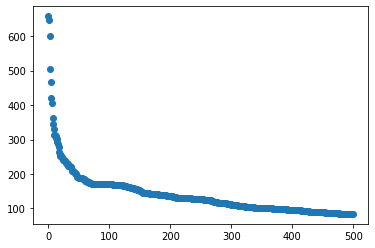

In [ ]:
plt.scatter([i for i in range(len(pairs))][:500], [unique_pair_count[k] for k in pairs][:500])

###Finding unique external mails 
Unique external senders and recipients have been noted as they are vents for the organisational information to escape.



In [ ]:
outside_sent_mails = set()
for i in unique_from_count.keys():
  if 'enron' not in i:
    outside_sent_mails.add(i) 

In [ ]:
outside_sent_mails

{'michael.hayes@beachfire.com',
 'fruitsalad@quickmail.quickhosts.com',
 'greg.malcolm@ontariopowergeneration.com',
 'carla_j@compuserve.com',
 'juliebrandimarte@hotmail.com',
 'marketinfo2002460782@yahoo.com',
 'hotdeals.26@reply.pm0.net',
 'tom-jerilynn@worldnet.att.net',
 'tz3qu@msn.com',
 'dana@gablegroup.com',
 'support@learningco.com',
 'gljackson2@tva.gov',
 'pclaassen@svmg.org',
 'listannouncefrom@dmband.com',
 'ccernosek@aep.com',
 'sustanle@utilicorp.com',
 'mainesa@natfuel.com',
 'mcortez@govadv.com',
 'ksullivan@hopebeckham.com',
 'ypoforumsurvey@ypoforumdiagnosticsurvey.com',
 'ryanb@gosfgiants.com',
 'ksterling@sterlingandassociates.com',
 'buy.com@enews.buy.com',
 'darrin_presto@rsd.edu',
 'especials@specials.ovm.com',
 'mhughes@hollandhart.com',
 'jking100@aol.com',
 'software@opt15.edirectnetwork.net',
 'expediatraveldeals_031352@expedia.customer-email.com',
 'jgedwards@hotmail.com',
 'philblunt2@isitpat.com',
 'matt.sample@enform.com',
 'lmoore@houstontech.org',
 'akr

In [ ]:
outside_received_mails = set()
for i in unique_to_count.keys():
  if 'enron' not in i:
    outside_received_mails.add(i) 

In [ ]:
outside_received_mails

{'corrier@cox-internetcom',
 'csunser@worldnetattnet',
 'ckaitson@midcoastenergycom',
 'andersg@kealincolnacnz',
 'brivers@telconetnet',
 'slokopriva@aolcom',
 'masterdave27@aolcom',
 'sboyle@haasberkeleyedu',
 'aperez@caisocom',
 'zibam@theticketcompanycom',
 'stephenbrown@rbcdaincom',
 'dgrueneich@gralegalcom',
 'mhammond@scanacom',
 'shackleton@worldnetattnet',
 'stink17@prodigynet',
 'mjgriffin@dowcom',
 'cestephenson@msncom',
 'kknitte@gcpudorg',
 'wmckenzie@dallasnewscom',
 'cartagenao@conedcom',
 'kinneary@bellatlanticnet',
 'dianamartinez@phcaetnacom',
 'doodoc@hotmailcom',
 'gaylasue1@aolcom',
 'mamiller@marathonoilcom',
 'david-barker@reliantenergycom',
 'imjt@dellnetcom',
 'kareneholub@usaconococom',
 'terrystein@prodigynet',
 'mweigle@unmedu',
 'grahamgwl@aolcom',
 'ccarver@alfers-carvercom',
 'mhutchins@aglresourcescom',
 'marci_paraboschi@timeinccom',
 'mcfeesha@aolcom',
 'jennifer_smock@gucciit',
 'gdausman@hotmailcom',
 'tim_stringer@transcanadacom',
 'gbollom@mgecom',


###Creating new features

In [ ]:
outside_sender = [0 for _ in range(len(data))] # marking the mail if it involves an outsider sender
for i in range(len(data.From)):
  if data.From[i] in outside_sent_mails:
    outside_sender[i] = 1

In [ ]:
outside_sent_mails

{'michael.hayes@beachfire.com',
 'fruitsalad@quickmail.quickhosts.com',
 'greg.malcolm@ontariopowergeneration.com',
 'carla_j@compuserve.com',
 'juliebrandimarte@hotmail.com',
 'marketinfo2002460782@yahoo.com',
 'hotdeals.26@reply.pm0.net',
 'tom-jerilynn@worldnet.att.net',
 'tz3qu@msn.com',
 'dana@gablegroup.com',
 'support@learningco.com',
 'gljackson2@tva.gov',
 'pclaassen@svmg.org',
 'listannouncefrom@dmband.com',
 'ccernosek@aep.com',
 'sustanle@utilicorp.com',
 'mainesa@natfuel.com',
 'mcortez@govadv.com',
 'ksullivan@hopebeckham.com',
 'ypoforumsurvey@ypoforumdiagnosticsurvey.com',
 'ryanb@gosfgiants.com',
 'ksterling@sterlingandassociates.com',
 'buy.com@enews.buy.com',
 'darrin_presto@rsd.edu',
 'especials@specials.ovm.com',
 'mhughes@hollandhart.com',
 'jking100@aol.com',
 'software@opt15.edirectnetwork.net',
 'expediatraveldeals_031352@expedia.customer-email.com',
 'jgedwards@hotmail.com',
 'philblunt2@isitpat.com',
 'matt.sample@enform.com',
 'lmoore@houstontech.org',
 'akr

In [ ]:
outside_sender

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
data['Outside Sender'] = outside_sender

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
outside_receiver = [0 for _ in range(len(data))] # marking the mail if it involves outsider receiver
for i in range(len(data.To)):
  try:
    s = data.To[i].replace('\n','').replace('\t','').replace('e-mail','').replace('<','').replace('>','').replace('.','').replace(' ','').replace("''",'').replace("'",'')
    if ',' in s:
      for mail in s.split(','):
        if mail in outside_received_mails:
          outside_receiver[i] +=1
    else:
      if s in outside_received_mails:
        outside_receiver[i] +=1
  except:
    pass

In [ ]:
outside_receiver

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
data['Outside Receiver'] = outside_receiver

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# creating new feature to detect sporadic mails which can show significant events
fraction_sent = [0 for _ in range(len(data))]
for i in range(len(data)):
  if unique_from_count[data.From[i]]>30: # only considering cases where the employee has significant reception 
          fraction_sent[i] += 1/unique_from_count[data.From[i]]

In [ ]:
unique_from_count

{'lkunkel@trigon-sheehan.com': 6,
 'darrell.schoolcraft@enron.com': 504,
 'tk.lohman@enron.com': 133,
 'ron.matthews@enron.com': 59,
 'jeanne.licciardo@enron.com': 4,
 'michelle.lokay@enron.com': 426,
 'david.roensch@enron.com': 50,
 'elizabeth.brown@enron.com': 79,
 'mansoor.abdmoulaie@enron.com': 37,
 'richard.hanagriff@enron.com': 59,
 'melinda.gallishaw@enron.com': 15,
 'max.brown@enron.com': 6,
 'maria.salazar@enron.com': 1,
 'enron.payroll@enron.com': 29,
 'michael.bodnar@enron.com': 71,
 'john.sturn@enron.com': 17,
 'ramona.betancourt@enron.com': 39,
 'rc@mail.greeting-cards.com': 3,
 'team.cunningham@enron.com': 4,
 'newsletter@rigzone.com': 69,
 'charlie.yuan@enron.com': 1,
 'bart.monden@enron.com': 8,
 'mschneider@duke-energy.com': 32,
 'jerry.graves@enron.com': 154,
 'toby.kuehl@enron.com': 48,
 'stoverron1@aol.com': 1,
 'lynn.blair@enron.com': 987,
 'steve.january@enron.com': 53,
 'nancy.callans@enron.com': 21,
 'thill@cfbc.org': 1,
 'randy.janzen@enron.com': 63,
 'sharon.b

In [ ]:
# creating new feature to detect sporadic mails which can show significant events
fraction_received = [0 for _ in range(len(data))]
for i in range(len(data)):
  try:
    s = s.replace('\n','').replace('\t','').replace('e-mail','').replace('<','').replace('>','').replace('.','').replace(' ','').replace("''",'').replace("'",'')
    if ',' in s:
      for mail in s.split(','):
        if unique_to_count[mail]>30: # only considering cases where the employee has significant reception 
          fraction_received[i] += 1/unique_to_count[mail]
    else:
      if unique_to_count[mail]>30: # only considering cases where the employee has significant reception 
          fraction_received[i] += 1/unique_to_count[mail]
  except:
    pass

In [ ]:
data['Fraction Sent'] = fraction_sent
data['Fraction Received'] = fraction_received

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
fraction_sent

[0,
 0.001984126984126984,
 0.001984126984126984,
 0.007518796992481203,
 0.007518796992481203,
 0.001984126984126984,
 0.001984126984126984,
 0.001984126984126984,
 0.01694915254237288,
 0.001984126984126984,
 0,
 0.001984126984126984,
 0.001984126984126984,
 0.001984126984126984,
 0.002347417840375587,
 0.02,
 0.001984126984126984,
 0.001984126984126984,
 0.012658227848101266,
 0.02702702702702703,
 0.01694915254237288,
 0,
 0,
 0,
 0.001984126984126984,
 0.001984126984126984,
 0.001984126984126984,
 0.001984126984126984,
 0.001984126984126984,
 0.001984126984126984,
 0.001984126984126984,
 0.001984126984126984,
 0.001984126984126984,
 0.001984126984126984,
 0.001984126984126984,
 0.001984126984126984,
 0.001984126984126984,
 0.001984126984126984,
 0.001984126984126984,
 0.001984126984126984,
 0.001984126984126984,
 0.001984126984126984,
 0.001984126984126984,
 0.001984126984126984,
 0.001984126984126984,
 0.001984126984126984,
 0.001984126984126984,
 0.001984126984126984,
 0.0019841

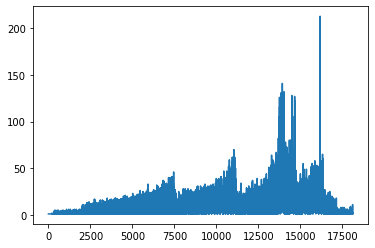

In [ ]:
plt.plot([i for i in range(len(grouped.nunique()['From']))],grouped.nunique()['From'])

In [ ]:
# creating a new feature to detect sudden new pairs of nodes communicating
fraction_communication = [0 for _ in range(len(data))]

for i in data.index:
  try:
    s = data.To[i]
    source = data.From[i]
    s = s.replace('\n','').replace('\t','').replace('e-mail','').replace('<','').replace('>','').replace('.','').replace(' ','').replace("''",'').replace("'",'')
    if ',' in s:
      for mail in s.split(','):
        key = source+' '+mail
        if unique_pair_count[key]>30: # consider only significant communications
          fraction_communication[i] += 1/unique_pair_count[key]
    else:
      key = source+' '+data.To[i]
      if unique_pair_count[key]>30: # consider only significant communications
          fraction_communication[i] += 1/unique_pair_count[key]
  except:
    pass

In [ ]:
fraction_communication

[0,
 0,
 0,
 0,
 0.0668231544491343,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.03225806451612903,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.17877424389914323,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.2327714388500549,
 0,
 0,
 0,
 0.1438650659153578,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.2327714388500549,
 0,
 0,
 0,
 0,
 0,
 0.20051337433392585,
 0,
 0.2327714388500549,
 0.2327714388500549,
 0,
 0,
 0.2327714388500549,
 0,
 0.03225806451612903,
 0,
 0,
 0,
 0,
 0,
 0,
 0.1761231304314868,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.20051337433392585,
 0,
 0.20051337433392585,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.1761231304314868,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.03225806451612903,
 0.1761231304314868,
 0,
 0,
 0.2327714388500549,
 0.03225806

In [ ]:
data['Fraction Communication'] = fraction_communication

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


###Creating data
Creating numpy array which has all features to consider for final anomaly detection

In [ ]:
grouped = data.groupby(by = (times.date, times.hour))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


In [ ]:
grouped.sum().columns # printing all columns being used as features

Index(['Content Length', 'Reply', 'Outside Sender', 'Outside Receiver',
       'Fraction Sent', 'Fraction Received', 'Fraction Communication'],
      dtype='object')

In [ ]:
# adding number of unique sources and number of mails too per hour
x = np.column_stack([grouped.sum()[i] for i in grouped.sum().columns]+[grouped.nunique()['From']]+[grouped.count()['Message-ID']])

In [ ]:
x

array([[ 25.,   0.,   0., ...,   0.,   1.,   1.],
       [942.,   0.,   1., ...,   0.,   1.,   1.],
       [194.,   0.,   1., ...,   0.,   1.,   1.],
       ...,
       [215.,   0.,   1., ...,   0.,   1.,   1.],
       [152.,   0.,   1., ...,   0.,   1.,   1.],
       [225.,   0.,   1., ...,   0.,   1.,   1.]])

In [ ]:
x.shape

(18127, 9)

###Visualising

In [ ]:
final_features = list(grouped.sum().columns)
final_features =  final_features + ['Unique Senders'] + ['Number of mails']

In [ ]:
final_features # list of all features

['Content Length',
 'Reply',
 'Outside Sender',
 'Outside Receiver',
 'Fraction Sent',
 'Fraction Received',
 'Fraction Communication',
 'Unique Senders',
 'Number of mails']

In [ ]:
x

array([[ 25.,   0.,   0., ...,   0.,   1.,   1.],
       [942.,   0.,   1., ...,   0.,   1.,   1.],
       [194.,   0.,   1., ...,   0.,   1.,   1.],
       ...,
       [215.,   0.,   1., ...,   0.,   1.,   1.],
       [152.,   0.,   1., ...,   0.,   1.,   1.],
       [225.,   0.,   1., ...,   0.,   1.,   1.]])

In [ ]:
smooth_width = 25 # using moving window to smoothen the curve
smooth_x = np.array([x[i:i+smooth_width].mean(axis=0) for i in range(len(x)-smooth_width)])

In [ ]:
smooth_x

array([[1.61480e+02, 0.00000e+00, 1.20000e-01, ..., 0.00000e+00,
        1.00000e+00, 1.00000e+00],
       [1.62600e+02, 0.00000e+00, 1.20000e-01, ..., 0.00000e+00,
        1.00000e+00, 1.00000e+00],
       [1.25640e+02, 0.00000e+00, 8.00000e-02, ..., 0.00000e+00,
        1.00000e+00, 1.00000e+00],
       ...,
       [7.44936e+03, 4.00000e-02, 1.80000e+00, ..., 0.00000e+00,
        1.96000e+00, 2.28000e+00],
       [7.39524e+03, 4.00000e-02, 1.84000e+00, ..., 0.00000e+00,
        1.96000e+00, 2.28000e+00],
       [7.35444e+03, 4.00000e-02, 1.88000e+00, ..., 0.00000e+00,
        1.96000e+00, 2.28000e+00]])

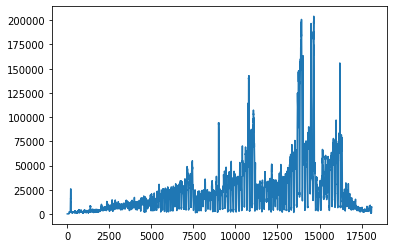

Content Length


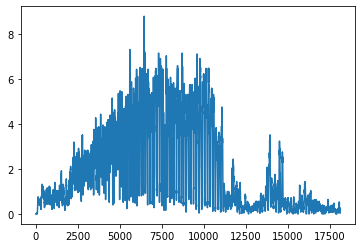

Reply


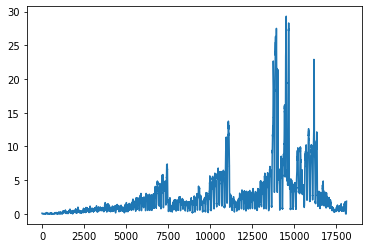

Outside Sender


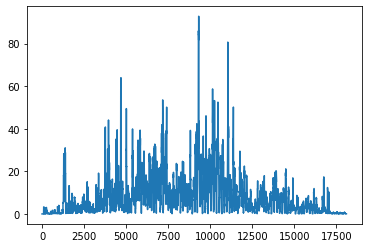

Outside Receiver


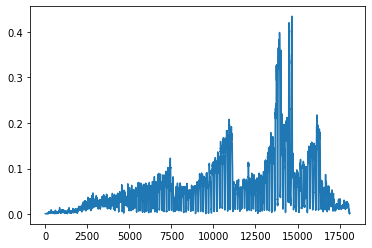

Fraction Sent


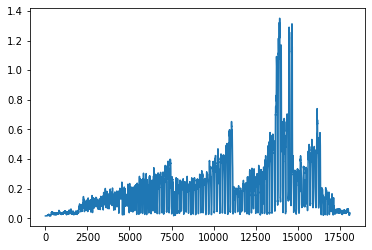

Fraction Received


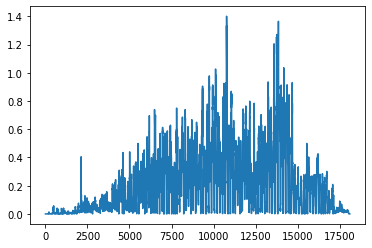

Fraction Communication


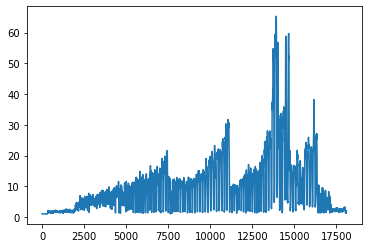

Unique Senders


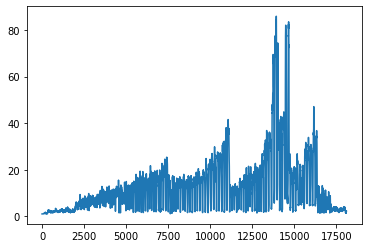

Number of mails


In [ ]:
for i in range(len(final_features)):
  plt.plot([i for i in range(len(smooth_x))],smooth_x.T[i].T)
  plt.show()
  print(final_features[i])

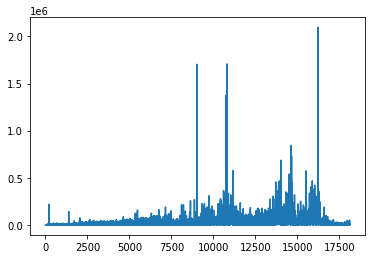

Content Length


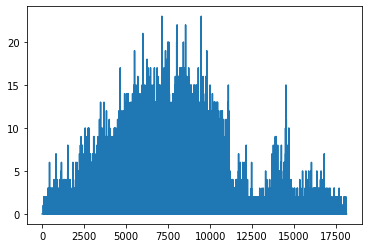

Reply


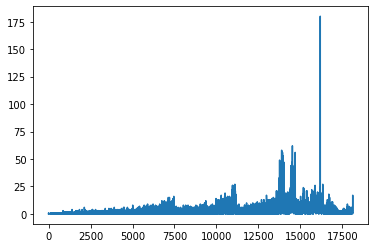

Outside Sender


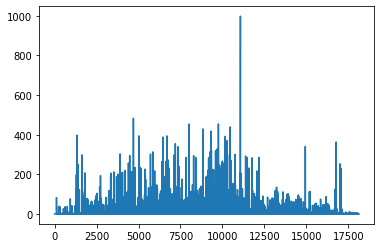

Outside Receiver


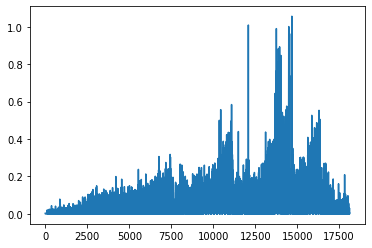

Fraction Sent


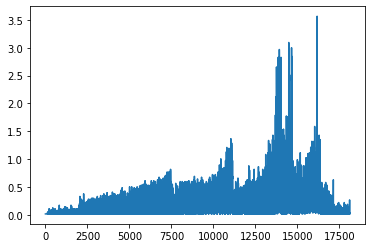

Fraction Received


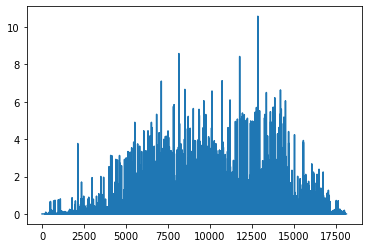

Fraction Communication


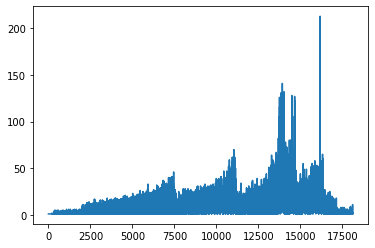

Unique Senders


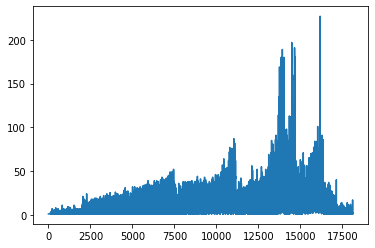

Number of mails


In [ ]:
for i in range(len(final_features)):
  plt.plot([i for i in range(len(x))],x.T[i].T)
  plt.show()
  print(final_features[i])

In [ ]:
data.to_csv('dataset.csv')

##Creating final anomaly detection system using Isolation Forest

In [ ]:
# normalising features by number of mails
x.T[-2] = x.T[-2]/x.T[-1]
x.T[-4] = x.T[-4]/x.T[-1]
x.T[-7] = x.T[-7]/x.T[-1]

In [ ]:
# z score normalisation
x_m = x.mean(axis=0)
x_s = x.std(axis=0)
normed_x = (x-x_m)/x_s

In [ ]:
x_m

array([2.33194646e+04, 1.88950185e+00, 2.67246075e-01, 8.03453412e+00,
       5.32906714e-02, 1.57088696e-02, 1.99536603e-01, 8.46197159e-01,
       1.23611739e+01])

In [ ]:
x_s

array([4.92128293e+04, 3.02080530e+00, 3.23020280e-01, 2.88320758e+01,
       8.92652594e-02, 4.08513577e-15, 5.87161922e-01, 1.79210686e-01,
       1.82587829e+01])

In [ ]:
x.shape

(18127, 9)

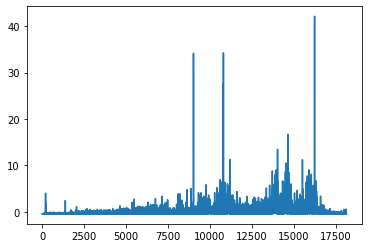

Content Length


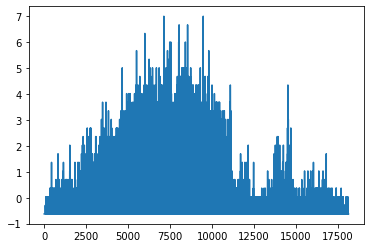

Reply


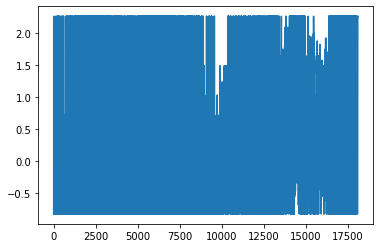

Outside Sender


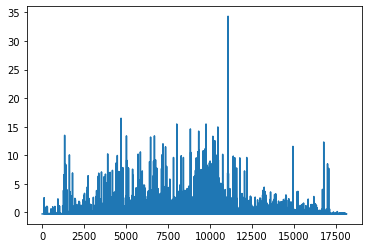

Outside Receiver


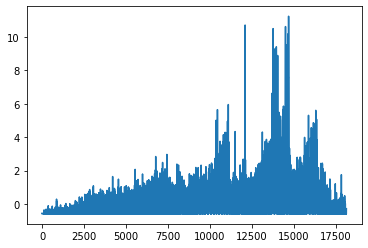

Fraction Sent


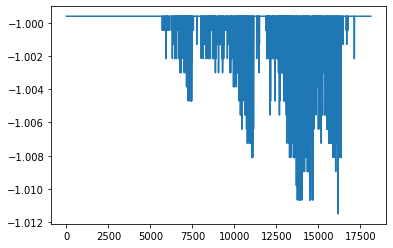

Fraction Received


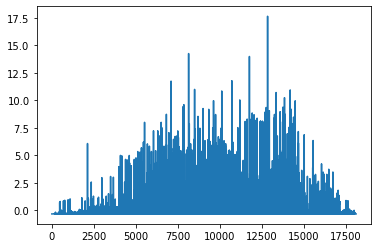

Fraction Communication


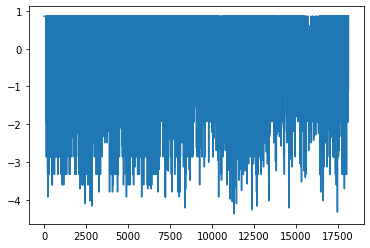

Unique Senders


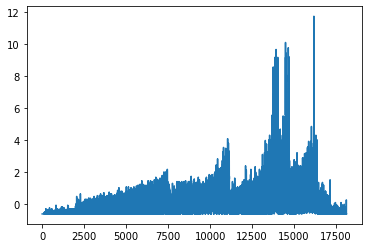

Number of mails


In [ ]:
for i in range(len(final_features)):
  plt.plot([_ for _ in range(len(normed_x))],normed_x.T[i].T)
  plt.show()
  print(final_features[i])

when number of mails is factored into the features; most features end up becoming white noise and thus are redundent. These features can then be removed.

In [ ]:
x_new = np.column_stack([normed_x.T[0],normed_x.T[1],normed_x.T[3],normed_x.T[6],normed_x.T[8]])

In [ ]:
model = IsolationForest(contamination=0.03,n_estimators=1000, verbose=3)

In [ ]:
y = model.fit_predict(x_new)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 1000 for this parallel run (total 1000)...
Building estimator 2 of 1000 for this parallel run (total 1000)...
Building estimator 3 of 1000 for this parallel run (total 1000)...
Building estimator 4 of 1000 for this parallel run (total 1000)...
Building estimator 5 of 1000 for this parallel run (total 1000)...
Building estimator 6 of 1000 for this parallel run (total 1000)...
Building estimator 7 of 1000 for this parallel run (total 1000)...
Building estimator 8 of 1000 for this parallel run (total 1000)...
Building estimator 9 of 1000 for this parallel run (total 1000)...
Building estimator 10 of 1000 for this parallel run (total 1000)...
Building estimator 11 of 1000 for this parallel run (total 1000)...
Building estimator 12 of 1000 for this parallel run (total 1000)...
Building estimator 13 of 1000 for this parallel run (total 1000)...
Building estimator 14 of 1000 for this parallel run (total 1000)...
Building estimator 15 of 1000 for this parallel run (tota

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


In [ ]:
print(sum(y==-1))

544


In [ ]:
print(sum(y==1))

17583


In [ ]:
x_out = x_new[y==-1]
x_in = x_new[y==1]

In [ ]:
x_coord = np.array([i for i in range(len(x_new))])
x_coord_out = x_coord[y==-1]
x_coord_in = x_coord[y==1]

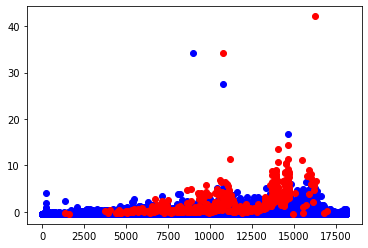

Content Length


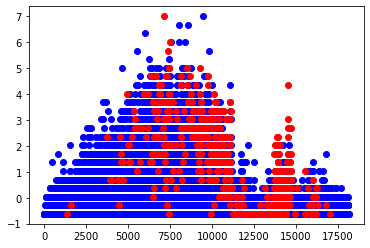

Reply


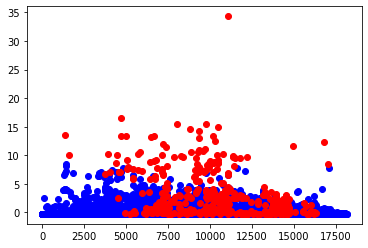

Outside Receiver


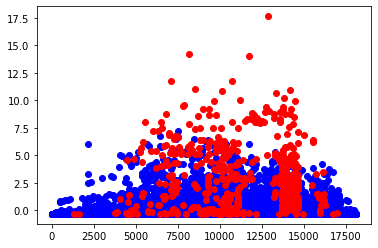

Fraction Communication


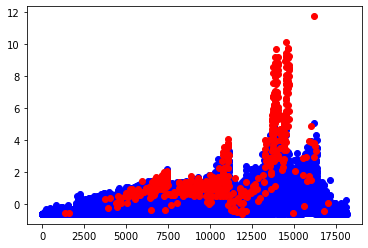

Number of mails


In [ ]:
for i in range(x_new.shape[1]):
  plt.scatter(x_coord_in,x_in.T[i].T,c='b')
  plt.scatter(x_coord_out,x_out.T[i].T,c='r')
  plt.show()
  print(final_features[list([0,1,3,6,8])[i]])

As it can be clearly seen, most of the outliers are now being detected and flagged. The number of flagged cases is about 550 hours out of 18000 hours which can be analyzed as it is only about 3% of all the cases.

In [ ]:
550/18000

0.030555555555555555